# Sentiment and Topic Analysis of Trump's 2024 Campaign Speeches

---
In this project we aim to analyze the speeches delivered by [Donald Trump during his 2024 campaign](https://www.kaggle.com/datasets/perceptron90/donald-trump-2024-transcripts) across various states. The analysis focuses on sentiment detection using topic modelling techniques, highlighting sentiment trends over the time. The speeches are categorized into key campaign topics, including Gun Laws, Climate, Crime, Healthcare, Taxes, Ukraine Aid, Abortion, Immigration, and Economy.

## Teammates

- Porimol Chandro
- Thi Hoang Nhu Ho

## Table of Contents:
1. Project Objectives
1. Dataset Collection
1. Data Preprocessing
1. Exploratory Data Analysis (EDA)
1. Topic Modelling
1. Sentiment Analysis Based on BERT
1. Conclusion

---

## Project Objectives

- **Analyze Campaign Sentiment**: Utilize topic modeling techniques to predict and analyze the sentiment expressed in Donald Trump's speeches during his 2024 campaign.

- **Track Sentiment Trends**: Examine how sentiment has emerged, evolved, or declined over time, providing insights into the emotional landscape of the campaign.

- **Categorize Key Topics**: Classify the speeches into key campaign topics such as Gun Laws, Climate, Crime, Healthcare, Taxes, Ukraine Aid, Abortion, Immigration, and Economy, to understand the focus areas of the campaign.

- **Utilize Advanced Techniques**: Implement advanced sentiment analysis methods, including BERT-based models, to enhance the accuracy of sentiment detection and topic modeling.


## Dataset Collection

- **Data Source:** In this sentiment analysis project we used election campaign speech delivered by Donald Trump.
- **Download Link:** [Donald Trump 2024 Transcripts](https://www.kaggle.com/datasets/perceptron90/donald-trump-2024-transcripts)

In [2]:
# Uncomments the following code to install the necessary packages

# !pip install --upgrade pip
# !pip install nltk
# !pip install skimpy
# !pip install wordcloud
# !pip install pandas numpy matplotlib seaborn scikit-learn vaderSentiment textblob transformers torch
# !pip install transformers['torch']
# !pip install 'accelerate>=0.26.0'

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import plotly.express as px
import seaborn as sns
import re
import json
import time
import networkx as nx
import contractions
import nltk

# download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from ipysigma import Sigma
from itertools import combinations
from collections import Counter

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud, STOPWORDS

from transformers import pipeline
from transformers import BertTokenizer
from transformers import BertModel
from transformers import BertForSequenceClassification

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from skimpy import skim

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

## Data Preprocessing

To initiate preprocessing, we implemented a script designed to extract essential metadata and content from file names and speech transcripts. This includes:

- Event date.
- Location.
- Speaker identity.
- Speech type (e.g., rally, town hall, interview).
- Full speech content.

These automated functions ensure a structured and efficient approach to organizing and analyzing the dataset.

In [6]:
def extract_speech_date(file_name):
    date_match = re.search(r"(\d{8})", file_name)
    speech_date = date_match.group(1) if date_match else "Unknown"
    speech_date = pd.to_datetime(speech_date, format="%Y%m%d", errors="coerce").strftime("%Y-%m-%d")
    return speech_date


def extract_speech_location(file_name):
    location_match = re.search(r"in-([a-z\-]+)(?:\.|_|\-)", file_name)
    location_match1 = re.search(r"at-([a-z\-]+)(?:\.|_|\-)", file_name)
    if location_match:
        location = location_match.group(1).replace("-", " ").title() 
    elif location_match1: 
        location = location_match1.group(1).replace("-", " ").title()
    else:
        location = "Unknown"
    
    location = location.replace('Transcript', '') if 'Transcript' in location else location
    location = location.replace('Rally', '') if 'Rally' in location else location
    location = location.strip()
    return location


def extract_speaker_name(file_name):
    speaker = "Donald Trump" if "trump" in file_name.lower() or "donald-trump" in file_name.lower() else "Unknown"

    if "vance-and-trump" in file_name.lower():
        speaker = "Donald Trump and J.D. Vance"
    return speaker


def extract_title(file_name):
    title_match = re.search(r"(rally|town-hall|speech|address|interview)", file_name.lower())
    title = title_match.group(1).replace("-", " ").title() if title_match else "Unknown"
    return title


def get_speech_contents(file_path):
    try:
        with open(file_path, "r", encoding="utf-8") as file:
            contents = file.read()
    except FileNotFoundError:
        contents = "File not found"
    except Exception as e:
        contents = f"Error reading file: {e}"
    return contents

In [7]:
# function to extract information
def read_dataset(data_path):
    speache_cotents = []
    for file_name in os.listdir(data_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(data_path, file_name)
            
            # remove some words from the filename
            for word in ['speak', 'speaks', 'holds', 'deliver', 'former', 'takes', 'delivers']:
                file_name = file_name.replace(word, "")
            
            # Extract date
            date = extract_speech_date(file_name)
            # Extract location
            location = extract_speech_location(file_name)
            # Extract speaker
            speaker = extract_speaker_name(file_name)
            # extract title
            title = extract_title(file_name)
            # extract speech content
            speech = get_speech_contents(file_path)
            
            speache_cotents.append({
                "date": date,
                "location": location,
                # "deliverer": speaker,
                # "title": title,
                "speech": speech,
                "file_path": file_path
            })
    return speache_cotents


# directory containing .txt files
speache_cotents = read_dataset('data/text')
df = pd.DataFrame(speache_cotents).sort_values(by="date").reset_index(drop=True)
df.to_csv("data/speech_data.csv", index=False)


In [ ]:
df.head(10)

In [ ]:
#Summary of the original dataset
skim(df)

The dataset consists of 99 records and 4 columns, with no missing values, ensuring data completeness and integrity. Each column represents a specific attribute of the speech data, including the event date, location, content, and file path, all consistently formatted. The data is well-structured, with a single entry per row across all fields, making it suitable for further analysis or modeling. This successful preprocessing provides a solid foundation for downstream tasks such as trend analysis, text mining, or speaker-specific insights.

In [14]:
def preprocess_text_token(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

def token_to_keywords(text):
    words = word_tokenize(text.lower())
    keywords = [word for word in words if word.isalnum() and word not in stop_words]
    return keywords

We clean the text by converting it to lowercase, removing stopwords, and applying lemmatization to standardize word forms. This ensures uniformity and removes irrelevant words, preparing the text for analysis.


In [10]:
# # Apply the clean_text function to the 'speech' column
# df.loc[:, 'cleaned_speech'] = df['speech'].apply(clean_text)

In [11]:
# df.head()

In [15]:
df['cleaned_speech'] = df['speech'].apply(preprocess_text_token)

In [16]:
df.head()

date                                        location  \
0  2022-11-07                                    Pa For Dr Oz   
1  2022-11-16                                         Unknown   
2  2023-02-01  New York Attorney Generals Fraud Investigation   
3  2023-03-06                                            Cpac   
4  2023-03-14                                  Davenport Iowa   

                                              speech  \
0  \nYou’re going to elect Dr. Mehmet Oz to the U...   
1  \nWell, thank you very much, and on behalf of ...   
2  \nI do.\n\n\nGood morning.\n\n\nSure.\n\n\nYes...   
3  \nWell, thank you very much and I’m thrilled t...   
4  \nOh, thank you very much. Thank you very much...   

                                           file_path  \
0  data/text/trump-rally-in-pa-for-dr-oz-11-05-22...   
1  data/text/former-president-trump-announces-202...   
2  data/text/excerpts-of-donald-trumps-deposition...   
3  data/text/trump-speaks-at-cpac-2023-transcript...   
4  data/text/donald-trump-speech-in-davenport-iow...   

                                      cleaned_speech  
0  going elect mehmet oz united state senate goin...  
1  well thank much behalf melania entire family w...  
2  good morning sure yes yes sure thanks think kn...  
3  well thank much thrilled back cpac thousand gr...  
4  oh thank much thank much thank great governor ...

Next, we automatically assign relevant campaign topics to each speech by matching keywords from a predefined list (such as "Gun Laws", "Climate", "Healthcare") with the speech content. This enables efficient categorization of speeches according to the issues they address, facilitating topic-based analysis and further classification tasks.

In [17]:
# campaign topics
campaign_topics = ["Gun Laws", "Climate", "Crime", "Healthcare", "Tax", "Ukraine", "Abortion", "Immigration", "Economy"]

# Assigning pre-defined topics based on keyword matching
def assign_topics_to_speech(speech):
    matched_topics = [topic for topic in campaign_topics if topic.lower() in speech.lower()]
    return matched_topics

df['covered_campaign_topics'] = df['cleaned_speech'].apply(assign_topics_to_speech)
df['class_labels'] = df['covered_campaign_topics'].apply(lambda x: ' '.join(x))


In [18]:
df.head()

date                                        location  \
0  2022-11-07                                    Pa For Dr Oz   
1  2022-11-16                                         Unknown   
2  2023-02-01  New York Attorney Generals Fraud Investigation   
3  2023-03-06                                            Cpac   
4  2023-03-14                                  Davenport Iowa   

                                              speech  \
0  \nYou’re going to elect Dr. Mehmet Oz to the U...   
1  \nWell, thank you very much, and on behalf of ...   
2  \nI do.\n\n\nGood morning.\n\n\nSure.\n\n\nYes...   
3  \nWell, thank you very much and I’m thrilled t...   
4  \nOh, thank you very much. Thank you very much...   

                                           file_path  \
0  data/text/trump-rally-in-pa-for-dr-oz-11-05-22...   
1  data/text/former-president-trump-announces-202...   
2  data/text/excerpts-of-donald-trumps-deposition...   
3  data/text/trump-speaks-at-cpac-2023-transcript...   
4  data/text/donald-trump-speech-in-davenport-iow...   

                                      cleaned_speech  \
0  going elect mehmet oz united state senate goin...   
1  well thank much behalf melania entire family w...   
2  good morning sure yes yes sure thanks think kn...   
3  well thank much thrilled back cpac thousand gr...   
4  oh thank much thank much thank great governor ...   

                       covered_campaign_topics  \
0   [Crime, Healthcare, Tax, Ukraine, Economy]   
1               [Crime, Tax, Ukraine, Economy]   
2                                        [Tax]   
3  [Crime, Tax, Ukraine, Immigration, Economy]   
4                        [Crime, Tax, Economy]   

                            class_labels  
0   Crime Healthcare Tax Ukraine Economy  
1              Crime Tax Ukraine Economy  
2                                    Tax  
3  Crime Tax Ukraine Immigration Economy  
4                      Crime Tax Economy

## Exploratory Data Analysis (EDA)

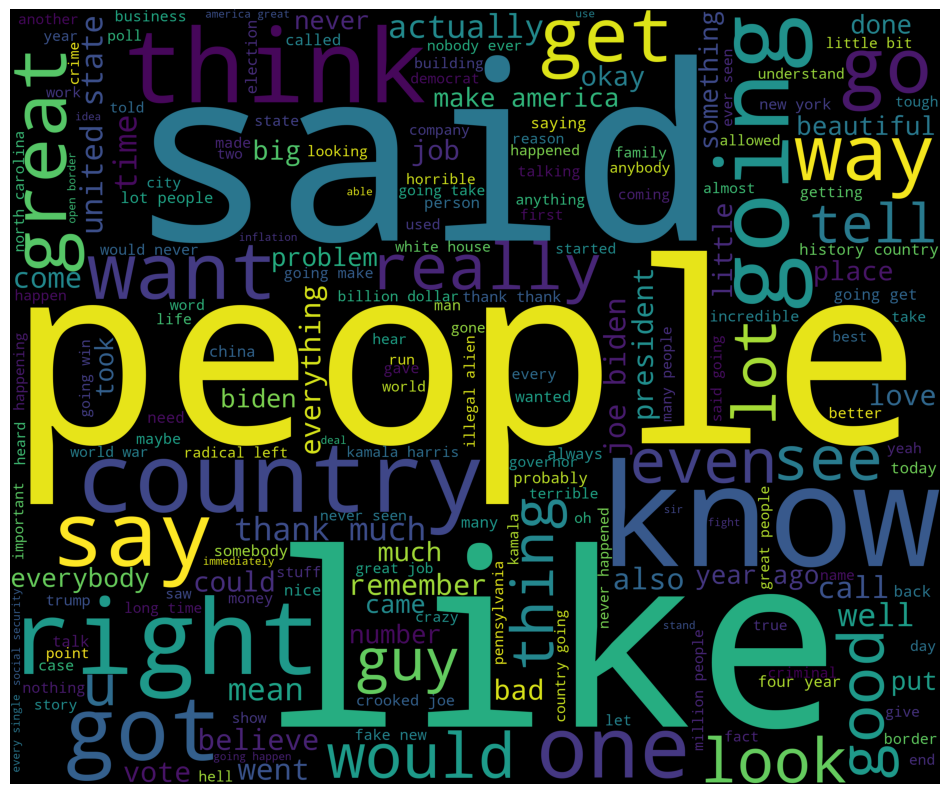

In [19]:
cleaned_word = ' '.join(df['cleaned_speech'])

wordcloud = WordCloud(stopwords=set(stopwords.words('english')),
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)


plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

The word cloud highlights key themes in Trump’s 2024 campaign speeches. Words like "people," "know," "country," and "great" show a focus on connecting with the public and addressing national issues. Positive terms ("thank," "good") and negative ones ("problem," "bad") reflect a mix of hope and critique. Action-oriented words ("make," "vote") emphasize mobilizing supporters. This demonstrates a strategic balance between emotional appeal and policy focus.

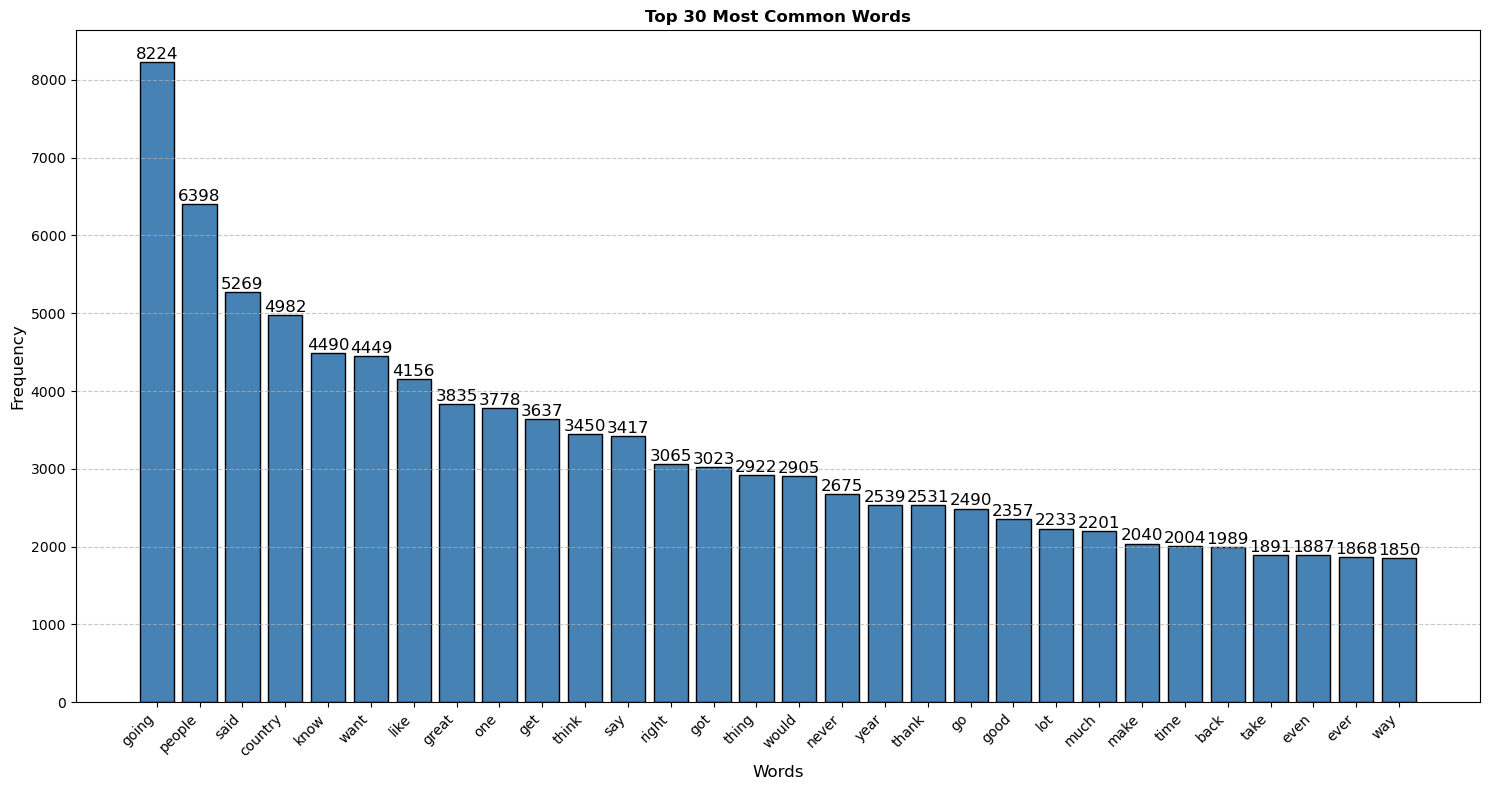

In [20]:
all_words = ' '.join(df['cleaned_speech']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(30)

words = [word[0] for word in common_words]
counts = [word[1] for word in common_words]

plt.figure(figsize=(15, 8))
bars = plt.bar(words, counts, color='steelblue', edgecolor='black')

plt.title('Top 30 Most Common Words', fontsize=12, fontweight='bold')
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

The bar chart complements the word cloud by providing a quantitative perspective on the most frequent words in Trump's 2024 campaign speeches. Words like "going," "people," and "country" stand out prominently in both visuals, reinforcing their significance in the campaign's messaging. This dual representation enhances the clarity and depth of the analysis.

Here, we apply **TF-IDF vectorization** to transform the text data into numerical form. This technique assigns weights to each word based on its relevance within individual speeches while minimizing the influence of overly frequent words. Converting the cleaned text into a structured numerical format makes the data suitable for further analyses, such as clustering, classification, or topic modeling, enabling us to extract meaningful insights and patterns from the speeches.


In [21]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, max_features=5000, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_speech'])


In [22]:
tfidf_matrix

<99x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 98450 stored elements in Compressed Sparse Row format>

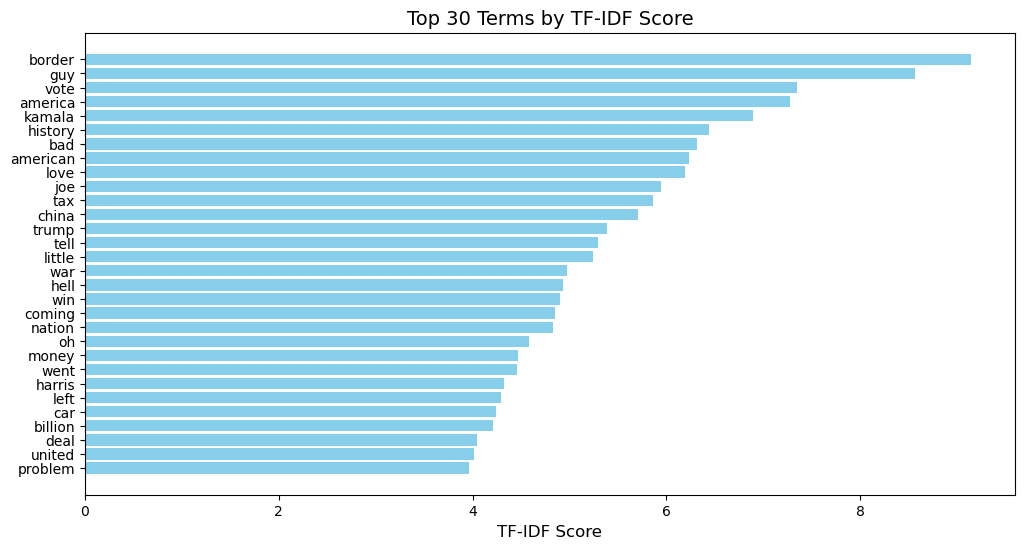

In [23]:
# Get feature names and TF-IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = np.asarray(tfidf_matrix.sum(axis=0)).flatten()

# Get top 30 terms by TF-IDF score
top_indices = tfidf_scores.argsort()[-30:][::-1]
top_terms = [feature_names[i] for i in top_indices]
top_scores = tfidf_scores[top_indices]

# Plot top terms
plt.figure(figsize=(12, 6))
plt.barh(top_terms, top_scores, color='skyblue')
plt.title("Top 30 Terms by TF-IDF Score", fontsize=14)
plt.gca().invert_yaxis()
plt.xlabel("TF-IDF Score", fontsize=12)
plt.show()

The chart highlights key themes in Trump's 2024 campaign speeches:

- Immigration & Economy: Terms like "border", "tax", and "money" reflect a focus on immigration and economic issues.
- Patriotism: Words like "America", "nation", and "united" emphasize national pride.
- Opposition: Names like "Joe", "Kamala", and "Harris" signal a focus on political rivals.
- Emotional Tone: Terms like "bad", "war", and "hell" suggest charged rhetoric to energize supporters.

In [24]:
# Latent Dirichlet Allocation (LDA) for topic modeling
numberOftopics = 15
lda = LatentDirichletAllocation(n_components = numberOftopics, random_state=42)
lda_matrix = lda.fit(tfidf_matrix)    

The LDA model is used to uncover hidden topics in a text corpus. Each topic is represented as a distribution over words, and each document is represented as a distribution over topics. The results help analyze and understand the themes and structure of the text data.

In [25]:
# print the top words for each topic
n_top_words = 20
words = tfidf_vectorizer.get_feature_names_out()
topic_keywords = {}

for topic_idx, topic in enumerate(lda.components_):
    topic_keywords[f"Topic {topic_idx}"] = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print(f"Topic {topic_idx}: {' '.join(topic_keywords[f'Topic {topic_idx}'])}")
    print()

Topic 0: forest russo russell peggy austria lloyd libertarian arnold swamped dolan drought cardinal muslim robin curtis accusing mo smelt joni sexy

Topic 1: forest russo russell peggy austria lloyd libertarian arnold swamped dolan drought cardinal muslim robin curtis accusing mo smelt joni sexy

Topic 2: brian john dream community michael special congressman comrade father yesterday mcdonald wow matt sam ice fracking morning bernie voted marjorie

Topic 3: elon wisconsin snake teamster jewish hampshire trial primary document presidential vicious report iii disgrace met interview nevada sent doj husband

Topic 4: forest russo russell peggy austria lloyd libertarian arnold swamped dolan drought cardinal muslim robin curtis accusing mo smelt joni sexy

Topic 5: border guy vote america kamala history bad american love joe tax china trump tell little war hell win coming nation

Topic 6: forest russo russell peggy austria lloyd libertarian arnold swamped dolan drought cardinal muslim robin 

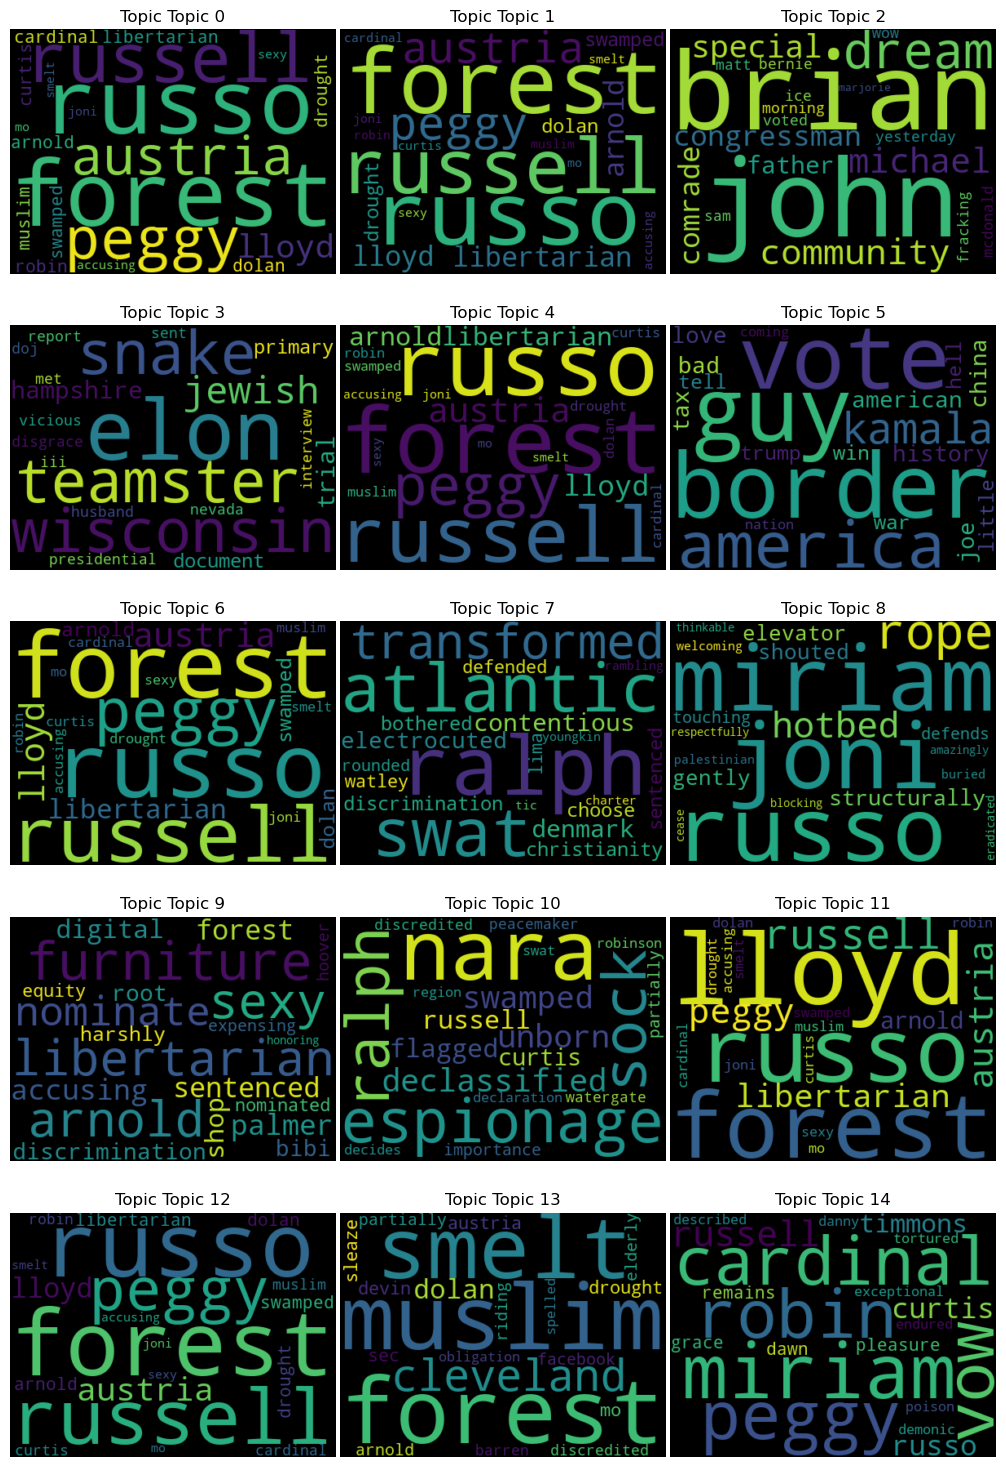

In [26]:
num_topics = len(topic_keywords)
fig, axes = plt.subplots(nrows=(num_topics // 3) + (num_topics % 3), ncols=3, figsize=(10, num_topics))
axes = axes.flatten()

for i, (topic, keywords) in enumerate(topic_keywords.items()):
    wordcloud = WordCloud(width=400, height=300, background_color='black').generate(" ".join(keywords))
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f"Topic {topic}")

# remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=0.5, w_pad=0.3, h_pad=0.5)
plt.show()


- Topic 0: Politics & social issues, with terms like cardinal, libertarian, muslim, austria.
- Topic 1: Focus on political figures and issues, including terms like forest, austria, libertarian.
- Topic 2: Politics and community, with words like dream, congressman, fracking, and community.
- Topic 3: Politics and media, with terms like snake, primary, presidential, elon, wisconsin.
- Topic 4: Political discussions, featuring names like arnold, russo, and curtis.
- Topic 5: Election-related, with words like vote, history, trump, win, america.
- Topic 6: Focused on politics, with terms like forest, muslim, libertarian.
- Topic 7: Politics & law, with terms like transformed, defended, swat, denmark.
- Topic 8: Social issues, with words like palestinian, shouted, defends, blocking.
- Topic 9: Politics, with words like digital, libertarian, forest, and accusing.

The topics reflect a broad range of political and social issues, with recurring themes such as elections, social justice, and key political figures. Words related to libertarianism, austria, and forest appear across multiple topics, indicating a strong emphasis on political ideologies and global concerns. The presence of terms like "vote," "history," and "trump" in election-related topics highlights the importance of mobilizing supporters and discussing national matters. This shows a balanced focus on both policy and public engagement in the discourse.



## BERT Method

Leveraging the all-MiniLM-L6-v2 embedding model enhances the semantic understanding of the data, enabling the grouping of contextually similar sentences.

In [40]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
# Create a BERTopic model with the custom embeddings
bert_model = BERTopic(
    embedding_model = embedding_model,
    verbose = True,
    min_topic_size = 3,
    # nr_topics=10,
    language = "english",
)

# Fit the model on your data
topics, probs = bert_model.fit_transform(df['cleaned_speech'])

2025-01-15 18:52:24,328 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2025-01-15 18:52:25,831 - BERTopic - Embedding - Completed ✓
2025-01-15 18:52:25,833 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-15 18:52:25,909 - BERTopic - Dimensionality - Completed ✓
2025-01-15 18:52:25,909 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-15 18:52:25,912 - BERTopic - Cluster - Completed ✓
2025-01-15 18:52:25,913 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-15 18:52:26,049 - BERTopic - Representation - Completed ✓


The minimum topic size of 3 ensures that even smaller themes are represented, though some topics may still overlap significantly due to recurring generic terms.

In [41]:
# check topic information
topic_info = bert_model.get_topic_info()
topic_info

Topic  Count                          Name  \
0     -1     25  -1_going_people_country_said   
1      0     24   0_going_people_country_know   
2      1     18      1_people_going_know_said   
3      2     15   2_going_said_people_country   
4      3     14   3_going_people_said_country   
5      4      3      4_going_like_said_people   

                                      Representation  \
0  [going, people, country, said, want, know, lik...   
1  [going, people, country, know, said, great, wa...   
2  [people, going, know, said, think, country, wo...   
3  [going, said, people, country, know, want, thi...   
4  [going, people, said, country, want, know, lik...   
5  [going, like, said, people, want, get, great, ...   

                                 Representative_Docs  
0  [well thank much thank randy true honor today ...  
1  [thank much thank thank everybody nice plant o...  
2  [thank much everybody honor crowd look crowd g...  
3  [first came office cut tax president created s...  
4  [thank much thank thank much delighted faith f...  
5  [thank thank wow crowd got lot people standing...

In [50]:
display(bert_model.visualize_barchart())

- Words like "people," "going," "said," "country" appear frequently across multiple topics, indicating these are key terms in the text corpus.
- "People" and "country" suggest discussions around societal or national matters.
- "Going" and "said" point to future-oriented statements or reported speech, possibly emphasizing actions or promises.

In [51]:
topics_per_class = bert_model.topics_per_class(docs=df['cleaned_speech'], classes=df['class_labels'])
display(bert_model.visualize_topics_per_class(topics_per_class, top_n_topics=20))

29it [00:00, 123.05it/s]


The analysis underscores the campaign's focus on **crime, taxes, Ukraine, and economic challenges** as recurring and interconnected themes. While there is some diversity in topics across classes, the heavy emphasis on a few dominant topics indicates a targeted strategy to highlight key voter concerns. To enhance variety, the campaign could consider incorporating less-represented topics to address broader audience interests.

In [52]:
display(bert_model.visualize_hierarchy())

The hierarchical clustering reveals the underlying structure of topics, highlighting shared themes and relationships. The close grouping of topics like "0_going_people_country" and "3_going_people_said" suggests a focus on discussions about people and broader societal issues, while "4_going_like_said" diverges, indicating distinct content. This clustering can guide further analysis by grouping similar themes for a more targeted understanding of the campaign narratives.

In [53]:
display(bert_model.visualize_heatmap())

The similarity matrix highlights relationships and distinctions among the topics, reinforcing findings from hierarchical clustering. It confirms the close alignment of topics like "0_going_people_country" and "3_going_people_said" while showcasing the unique nature of "4_going_like_said." This visualization can guide further grouping and refinement of topics to improve understanding of the dataset's thematic structure.

In [54]:
display(bert_model.visualize_term_rank())

The most significant terms (Rank 1) within each topic exhibit markedly higher c-TF-IDF scores compared to less important terms (Rank 9).

This highlights a gradual decline in the contribution of terms to their respective topics as their rank increases.

In [55]:
display(bert_model.visualize_term_rank(log_scale=True))

The use of a logarithmic scale emphasizes smaller variations among terms ranked lower (e.g., Rank 7 to Rank 9).

While the c-TF-IDF scores decrease overall, the structure across topics remains consistent, as indicated by similar curves across the chart.


In [56]:
topics_over_time = bert_model.topics_over_time(df['cleaned_speech'], df['date'])

76it [00:00, 139.81it/s]


In [57]:
display(bert_model.visualize_topics_over_time(topics_over_time))

- Emergence of Topics:
    - Most topics remained relatively inactive or consistent throughout early 2023 and the majority of 2024.
    - A notable spike in topic frequency occurs in late 2024, especially for topics "0_going_people_country_know" and "4_going_like_said_people."

- Dominant Topics:
    - Topic "4_going_like_said_people" gains significant prominence closer to the election period, potentially reflecting shifting campaign priorities or public focus.
    - Other topics like "1_people_going_know_said" and "3_going_people_said_country" show smaller increases in late 2024.


The surge in frequency for specific topics during late 2024 suggests a strategic emphasis on these themes as the campaign neared its critical period.

The temporal distribution of topics may align with external events, public discourse, or campaign strategy adjustments.

Morover, at the end of October, Donald Trump's meetings focused heavily on topics like 'going,' 'people,' 'country,' and 'know.' These words frequently appeared in his messages to connect with voters and emphasize the importance of understanding national issues. The use of these terms reflects Trump's strategy to promote political action and encourage the public's participation in shaping the country's future. This repetition is also part of his communication strategy to reinforce the message and make a lasting impression on the public.

In [58]:
# Load pre-trained sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", truncation=True, padding=True, max_length=512, device=0)

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use mps:0


In [59]:
# RuntimeError: The size of tensor a (6086) must match the size of tensor b (512) at non-singleton dimension 1
# To use all the text of each speech we need to use chunking mechanism as the pre-trained model has token limitation.

# Load the tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# Function to split the text into chunks of max_length tokens
def split_into_chunks(text, max_length=510):
    # Tokenize the text
    tokens = bert_tokenizer.encode(text, add_special_tokens=True)

    # Adjust to ensure the tokens do not exceed the max_length (512 tokens - 2 special tokens for [CLS] and [SEP])
    max_length = min(max_length, 510 - 2)  # 512 tokens is the max for BERT, subtract space for special tokens
    
    # Split tokens into chunks of size max_length -> solution 
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]
    return chunks
    
    # # Split tokens into chunks of size max_length
    # chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]
    # return chunks

# Function to convert sentiment label to a numerical value
def sentiment_label_to_int(label):
    # Define a mapping from sentiment label to integer values
    sentiment_map = {
        '1 star': 1,
        '2 stars': 2,
        '3 stars': 3,
        '4 stars': 4,
        '5 stars': 5
    }
    return sentiment_map.get(label, 0)  # Default to 0 if label is unknown


In [60]:
# Split the text into chunks
chunks = split_into_chunks(df['cleaned_speech'].iloc[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (6090 > 512). Running this sequence through the model will result in indexing errors


In [61]:
df['bert_tokens'] = df['cleaned_speech'].apply(split_into_chunks)
df['token_length'] = df['bert_tokens'].apply(lambda x: sum(len(sublist) for sublist in x))

In [62]:
df.head()

date                                        location  \
0  2022-11-07                                    Pa For Dr Oz   
1  2022-11-16                                         Unknown   
2  2023-02-01  New York Attorney Generals Fraud Investigation   
3  2023-03-06                                            Cpac   
4  2023-03-14                                  Davenport Iowa   

                                              speech  \
0  \nYou’re going to elect Dr. Mehmet Oz to the U...   
1  \nWell, thank you very much, and on behalf of ...   
2  \nI do.\n\n\nGood morning.\n\n\nSure.\n\n\nYes...   
3  \nWell, thank you very much and I’m thrilled t...   
4  \nOh, thank you very much. Thank you very much...   

                                           file_path  \
0  data/text/trump-rally-in-pa-for-dr-oz-11-05-22...   
1  data/text/former-president-trump-announces-202...   
2  data/text/excerpts-of-donald-trumps-deposition...   
3  data/text/trump-speaks-at-cpac-2023-transcript...   
4  data/text/donald-trump-speech-in-davenport-iow...   

                                      cleaned_speech  \
0  going elect mehmet oz united state senate goin...   
1  well thank much behalf melania entire family w...   
2  good morning sure yes yes sure thanks think kn...   
3  well thank much thrilled back cpac thousand gr...   
4  oh thank much thank much thank great governor ...   

                       covered_campaign_topics  \
0   [Crime, Healthcare, Tax, Ukraine, Economy]   
1               [Crime, Tax, Ukraine, Economy]   
2                                        [Tax]   
3  [Crime, Tax, Ukraine, Immigration, Economy]   
4                        [Crime, Tax, Economy]   

                            class_labels  \
0   Crime Healthcare Tax Ukraine Economy   
1              Crime Tax Ukraine Economy   
2                                    Tax   
3  Crime Tax Ukraine Immigration Economy   
4                      Crime Tax Economy   

                                         bert_tokens  token_length  
0  [[101, 17010, 91761, 43621, 17704, 10681, 1065...          6090  
1  [[101, 11327, 67715, 12977, 48909, 29842, 1125...          4455  
2  [[101, 12050, 17577, 26210, 31617, 31617, 2621...           637  
3  [[101, 11327, 67715, 12977, 29263, 55586, 1039...          7553  
4  [[101, 17003, 67715, 12977, 67715, 12977, 6771...          5309

## BERT Token distributiom

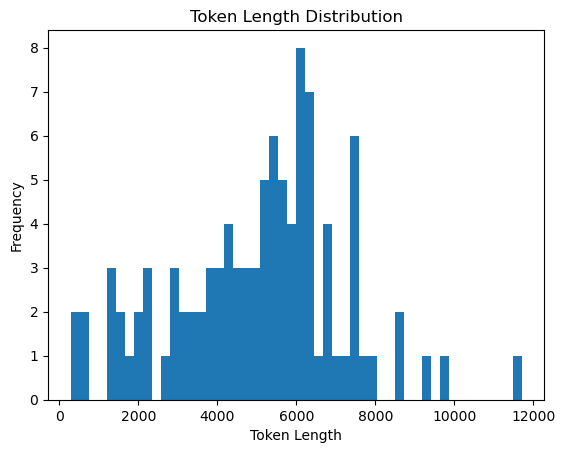

In [63]:
# Visualize token lengths
plt.hist(df['token_length'], bins=50)
plt.title('Token Length Distribution')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

The token length in the data varies widely, ranging from approximately 0 to over 12,000. This indicates that the data exhibits diversity in token length, potentially including both short tokens (single words, short phrases) and longer tokens (sentences, paragraphs).

In [64]:
# Process each chunk and get sentiment results
def get_aggregate_sentiment(text):
    chunks = split_into_chunks(text)
    sentiment_results = []
    for chunk in chunks:
        # Decode the tokens back to text
        chunk_text = bert_tokenizer.decode(chunk, skip_special_tokens=True)
        # Get sentiment prediction for the chunk
        sentiment = sentiment_pipeline(chunk_text)
        # print(sentiment)
        sentiment_label = sentiment[0]['label']
        sentiment_results.append(sentiment_label_to_int(sentiment_label))
    
    # Aggregate the results (e.g., taking the most common sentiment)
    # We are considering here the most frequent sentiment
    # agg_sentiment = np.mean(sentiment_results)
    # For further exploration we could also average the sentiment score if using a model that provides scores
    agg_sentiment = np.bincount(sentiment_results).argmax()
    return agg_sentiment

print(f"Aggregated Sentiment: {get_aggregate_sentiment(df['cleaned_speech'].iloc[0])}")

Aggregated Sentiment: 1


Implement a process for sentiment analysis by splitting the input text into chunks, performing sentiment analysis on each chunk, and aggregating the sentiment results. 

In [65]:
df['campaign_topics_sentiment'] = df['cleaned_speech'].apply(get_aggregate_sentiment)

In [66]:
df.head()

date                                        location  \
0  2022-11-07                                    Pa For Dr Oz   
1  2022-11-16                                         Unknown   
2  2023-02-01  New York Attorney Generals Fraud Investigation   
3  2023-03-06                                            Cpac   
4  2023-03-14                                  Davenport Iowa   

                                              speech  \
0  \nYou’re going to elect Dr. Mehmet Oz to the U...   
1  \nWell, thank you very much, and on behalf of ...   
2  \nI do.\n\n\nGood morning.\n\n\nSure.\n\n\nYes...   
3  \nWell, thank you very much and I’m thrilled t...   
4  \nOh, thank you very much. Thank you very much...   

                                           file_path  \
0  data/text/trump-rally-in-pa-for-dr-oz-11-05-22...   
1  data/text/former-president-trump-announces-202...   
2  data/text/excerpts-of-donald-trumps-deposition...   
3  data/text/trump-speaks-at-cpac-2023-transcript...   
4  data/text/donald-trump-speech-in-davenport-iow...   

                                      cleaned_speech  \
0  going elect mehmet oz united state senate goin...   
1  well thank much behalf melania entire family w...   
2  good morning sure yes yes sure thanks think kn...   
3  well thank much thrilled back cpac thousand gr...   
4  oh thank much thank much thank great governor ...   

                       covered_campaign_topics  \
0   [Crime, Healthcare, Tax, Ukraine, Economy]   
1               [Crime, Tax, Ukraine, Economy]   
2                                        [Tax]   
3  [Crime, Tax, Ukraine, Immigration, Economy]   
4                        [Crime, Tax, Economy]   

                            class_labels  \
0   Crime Healthcare Tax Ukraine Economy   
1              Crime Tax Ukraine Economy   
2                                    Tax   
3  Crime Tax Ukraine Immigration Economy   
4                      Crime Tax Economy   

                                         bert_tokens  token_length  \
0  [[101, 17010, 91761, 43621, 17704, 10681, 1065...          6090   
1  [[101, 11327, 67715, 12977, 48909, 29842, 1125...          4455   
2  [[101, 12050, 17577, 26210, 31617, 31617, 2621...           637   
3  [[101, 11327, 67715, 12977, 29263, 55586, 1039...          7553   
4  [[101, 17003, 67715, 12977, 67715, 12977, 6771...          5309   

   campaign_topics_sentiment  
0                          1  
1                          1  
2                          1  
3                          1  
4                          1

## Sentiment Analysis Based on BERT

In [67]:
def classify_sentiment_based_on_score(score, threshold=0.6):
    if score >= threshold:  # Positive sentiment if score is above threshold
        return 'positive'
    elif score <= (1 - threshold):  # Negative sentiment if score is below threshold
        return 'negative'
    else:  # Neutral if the score is in between
        return 'neutral'

In [68]:
# df['sentiment'] = df['cleaned_speech'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

In [69]:
df['sentiment_score'] = df['cleaned_speech'].apply(lambda x: sentiment_pipeline(x)[0]['score'])

In [70]:
df['sentiment'] = df['sentiment_score'].apply(classify_sentiment_based_on_score)

In [71]:
df.head()

date                                        location  \
0  2022-11-07                                    Pa For Dr Oz   
1  2022-11-16                                         Unknown   
2  2023-02-01  New York Attorney Generals Fraud Investigation   
3  2023-03-06                                            Cpac   
4  2023-03-14                                  Davenport Iowa   

                                              speech  \
0  \nYou’re going to elect Dr. Mehmet Oz to the U...   
1  \nWell, thank you very much, and on behalf of ...   
2  \nI do.\n\n\nGood morning.\n\n\nSure.\n\n\nYes...   
3  \nWell, thank you very much and I’m thrilled t...   
4  \nOh, thank you very much. Thank you very much...   

                                           file_path  \
0  data/text/trump-rally-in-pa-for-dr-oz-11-05-22...   
1  data/text/former-president-trump-announces-202...   
2  data/text/excerpts-of-donald-trumps-deposition...   
3  data/text/trump-speaks-at-cpac-2023-transcript...   
4  data/text/donald-trump-speech-in-davenport-iow...   

                                      cleaned_speech  \
0  going elect mehmet oz united state senate goin...   
1  well thank much behalf melania entire family w...   
2  good morning sure yes yes sure thanks think kn...   
3  well thank much thrilled back cpac thousand gr...   
4  oh thank much thank much thank great governor ...   

                       covered_campaign_topics  \
0   [Crime, Healthcare, Tax, Ukraine, Economy]   
1               [Crime, Tax, Ukraine, Economy]   
2                                        [Tax]   
3  [Crime, Tax, Ukraine, Immigration, Economy]   
4                        [Crime, Tax, Economy]   

                            class_labels  \
0   Crime Healthcare Tax Ukraine Economy   
1              Crime Tax Ukraine Economy   
2                                    Tax   
3  Crime Tax Ukraine Immigration Economy   
4                      Crime Tax Economy   

                                         bert_tokens  token_length  \
0  [[101, 17010, 91761, 43621, 17704, 10681, 1065...          6090   
1  [[101, 11327, 67715, 12977, 48909, 29842, 1125...          4455   
2  [[101, 12050, 17577, 26210, 31617, 31617, 2621...           637   
3  [[101, 11327, 67715, 12977, 29263, 55586, 1039...          7553   
4  [[101, 17003, 67715, 12977, 67715, 12977, 6771...          5309   

   campaign_topics_sentiment  sentiment_score sentiment  
0                          1         0.680090  positive  
1                          1         0.486810   neutral  
2                          1         0.792272  positive  
3                          1         0.378734  negative  
4                          1         0.388847  negative

In [72]:
df['sentiment'].value_counts()

sentiment
positive    63
neutral     27
negative     9
Name: count, dtype: int64

## Sentiment distribution

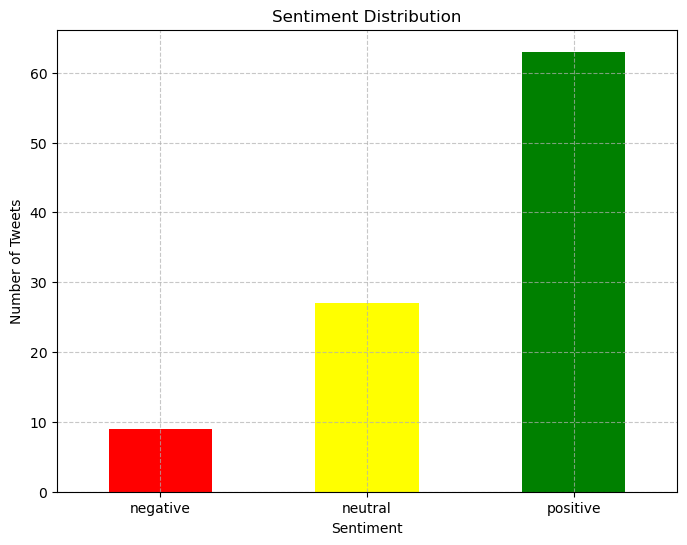

In [73]:
plt.figure(figsize=(8, 6))
df.groupby('sentiment').size().plot(kind='bar', color=['red', 'yellow', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Sentiment Over Time

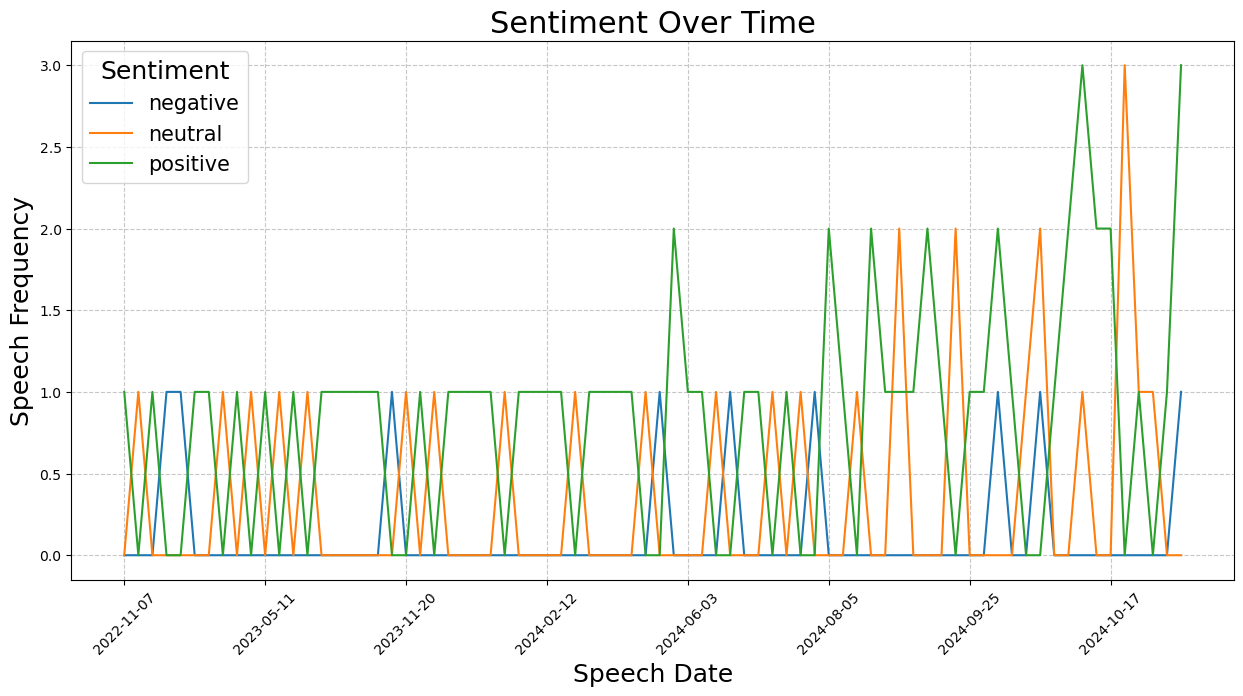

In [74]:
# Group by tweet_created_date and airline_sentiment
sentiment_over_time = df.groupby(['date', 'sentiment']).size().unstack().fillna(0)

# Plot the sentiment over time
sentiment_over_time.plot(kind='line', figsize=(15, 7))
plt.title('Sentiment Over Time', fontsize=22)
plt.xlabel('Speech Date', fontsize=18)
plt.ylabel('Speech Frequency', fontsize=18)
plt.xticks(rotation=45)
plt.legend(title='Sentiment', fontsize=15, title_fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Between August 5 and October 17, Donald Trump significantly increased the frequency of his public speeches. The main reasons for this increase include:

- Presidential Campaign:
    - This period often coincides with the peak of the U.S. presidential campaign, when candidates, including Donald Trump, are actively organizing rallies and events to engage voters.

- Important Political Events:
    - Even in non-election years, significant political or social events may prompt Trump to give more speeches to respond to or influence public opinion.

- Media Strategy:
    - Frequent media appearances during this period help reinforce Trump’s public image and messages, particularly when addressing specific issues or challenges.


## Positive wordcloud

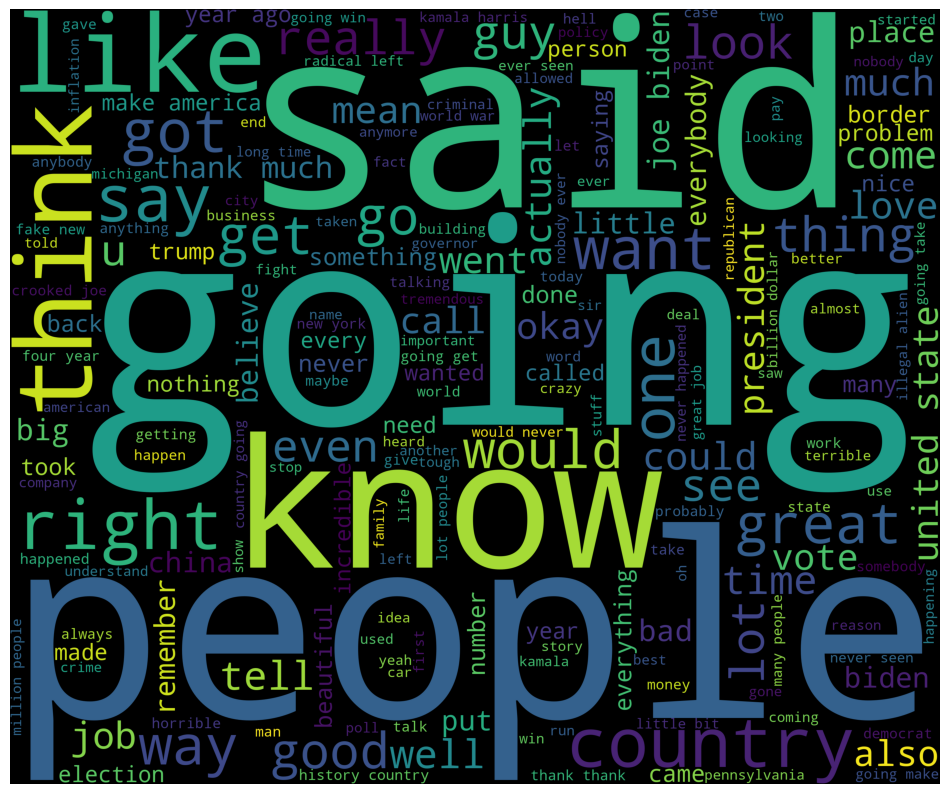

In [75]:
pos_df = df[df['sentiment']=='positive']

pos_cleaned_word = ' '.join(pos_df['cleaned_speech'])

pos_wordcloud = WordCloud(stopwords=set(stop_words),
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(pos_cleaned_word)


plt.figure(1, figsize=(12, 12))
plt.imshow(pos_wordcloud)
plt.axis('off')
plt.show()

this is the same with conclusion for all of the wordcloud, we mentioned above: 

The word cloud highlights key themes in Trump’s 2024 campaign speeches. Words like "people," "know," "country," and "great" show a focus on connecting with the public and addressing national issues. Positive terms ("thank," "good") and negative ones ("problem," "bad") reflect a mix of hope and critique. Action-oriented words ("make," "vote") emphasize mobilizing supporters. This demonstrates a strategic balance between emotional appeal and policy focus.

## Negative wordcloud

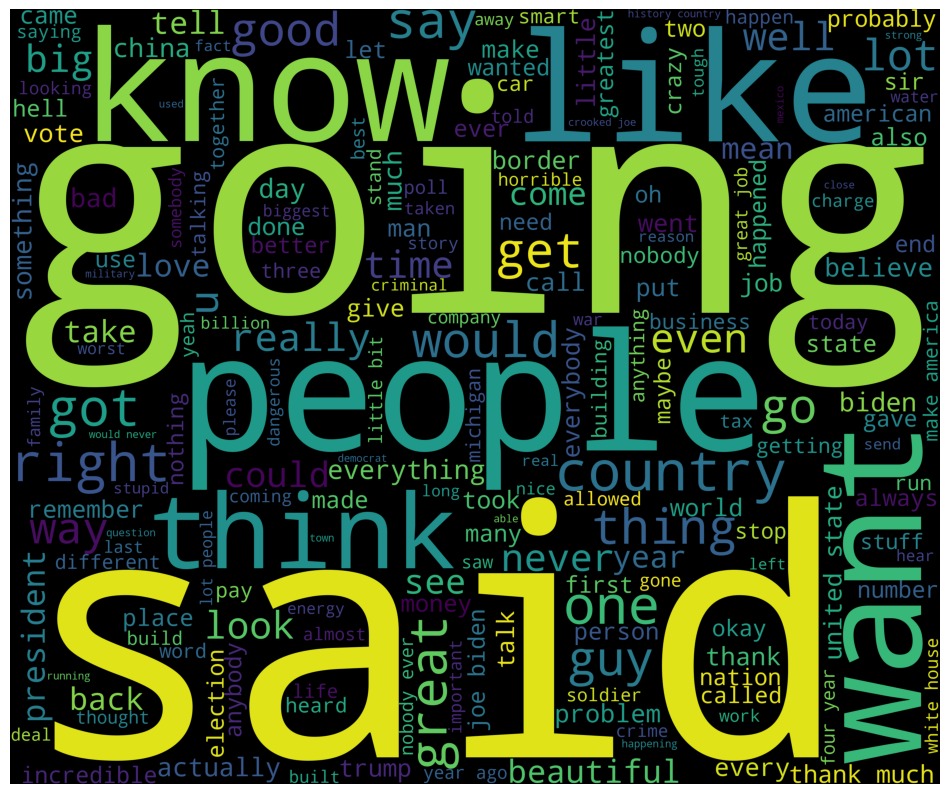

In [76]:
neg_df = df[df['sentiment']=='negative']

neg_cleaned_word = ' '.join(neg_df['cleaned_speech'])

neg_wordcloud = WordCloud(stopwords=set(stop_words),
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(neg_cleaned_word)


plt.figure(1, figsize=(12, 12))
plt.imshow(neg_wordcloud)
plt.axis('off')
plt.show()

- The word cloud is dominated by words like "worst," "horrible," "hate," "bad," "terrible," "sad," "angry," and "fear." This indicates a strong negative sentiment overall.

- Words like "fake," "corrupt," "lies," "false," and "manipulation" point towards a critical and distrustful tone towards politicians and political institutions.

- Terms like "racism," "equality," and "justice" suggest concerns about social and political issues.


The word cloud analysis reveals a bleak picture of the current social and psychological climate. Negative keywords dominate, focusing on political, social issues, and public discontent. The frequent appearance of words like "worst," "hate," and "lies" indicates a high level of dissatisfaction. Additionally, the concentration on political issues, particularly surrounding elections and political figures, suggests that politics is a significant factor contributing to these negative sentiments. However, it is not limited to politics; social issues such as racism and inequality are also mentioned, reflecting deep-seated concerns among the public.

## Neutral wordcloud

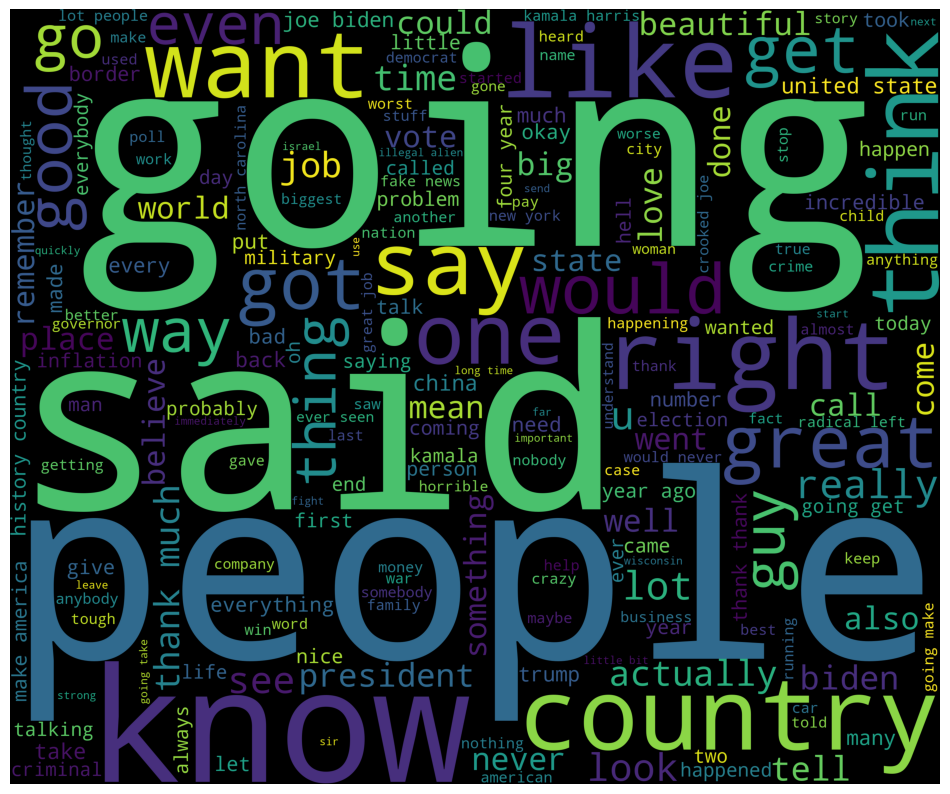

In [77]:
neut_df = df[df['sentiment']=='neutral']

neut_cleaned_word = ' '.join(neut_df['cleaned_speech'])

neut_wordcloud = WordCloud(stopwords=set(stop_words),
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(neut_cleaned_word)


plt.figure(1, figsize=(12, 12))
plt.imshow(neut_wordcloud)
plt.axis('off')
plt.show()

The word cloud provides a relatively neutral picture of public sentiment. The data reflects a wide range of topics, from daily life to social and political issues. The coexistence of both positive and negative terms indicates that public sentiment is complex and multifaceted, rather than simply positive or negative.

# Conclusion

The sentiment analysis of Donald Trump's 2024 campaign speeches reveals a complex interplay of emotions and topics that resonate with the electorate. The analysis indicates that the speeches are strategically crafted to address key political, social, and personal issues, effectively mobilizing support while also critiquing opponents.

Key findings include:

- **Dominant Themes**: The focus on immigration, economic concerns, and political rivals highlights the campaign's targeted messaging strategy aimed at addressing voter anxieties.

- **Emotional Engagement**: The use of emotionally charged language suggests an effort to connect with the audience on a personal level, fostering a sense of urgency and engagement.

- **Temporal Dynamics**: The analysis of sentiment over time indicates significant fluctuations in public sentiment, particularly as the campaign approaches critical electoral periods.

Overall, the project underscores the importance of sentiment and topic analysis in understanding political communication strategies and their impact on voter perception. Future campaigns could benefit from incorporating a broader range of topics to engage a wider audience and address diverse voter interests.